In [1]:
library(tidyverse)
library(edgeR)

Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"
-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.6     v purrr   0.3.4
v tibble  3.1.7     v dplyr   1.0.9
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: limma



## Import data into R

We have data from a control C2C12 differentiation timecourse and a fusion-inhibited C2C12 differentiation timecourse. Bulk short-read RNA-seq was performed at 0hr, 6hr, 12hr, 24hr, 48hr, and 72hr timepoints using polyA primers and Illumina sequencing. To quantify gene expression, reads were mapped to the mouse genome using [kallisto](https://pachterlab.github.io/kallisto/about), and the resulting counts matrix was saved as a tsv file. Normalized counts matrix (transcripts-per-million) was also saved as a tsv file. The metadata was constructed from the sample names.

In [2]:
tpm = read.csv("/data/class/cosmos-2022/PUBLIC/voyager/data/tpm_matrix.csv")
meta <- read.csv("/data/class/cosmos-2022/PUBLIC/voyager/data/c2c12_fusion_metadata.csv")


In [3]:
# reformat data frame to be a numerical matrix (same as before)
mat = tpm[,c(3:ncol(tpm))] # remove gene ID and gene name columns 1 and 2 because they are not numerical
rownames(mat) = tpm$Gene_ID


In [4]:
head(mat)

,Ctrl_0hr_A,Ctrl_0hr_B,Ctrl_0hr_C,Ctrl_6hr_A,Ctrl_6hr_B,Ctrl_6hr_C,Ctrl_12hr_A,Ctrl_12hr_B,Ctrl_12hr_C,Ctrl_24hr_A,...,FI_12hr_B,FI_12hr_C,FI_24hr_A,FI_24hr_C,FI_48hr_A,FI_48hr_B,FI_48hr_C,FI_72hr_A,FI_72hr_B,FI_72hr_C
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001.4,15.77810000,16.221900,14.2164000,11.2500000,12.600300,11.6668000,9.789400,9.3215300,9.3329000,9.91808000,...,9.72588000,7.453550,24.99960000,27.61810000,9.445430,5.2870900,7.32904000,3.81071000,3.364560,3.44736
ENSMUSG00000000003.15,0.00000000,0.000000,0.0000000,0.0000000,0.000000,0.0000000,0.000000,0.0000000,0.0000000,0.00000000,...,0.00000000,0.000000,0.00000000,0.00000000,0.000000,0.0000000,0.00000000,0.00000000,0.000000,0.00000
ENSMUSG00000000028.15,2.54072500,2.879890,3.5848250,2.4920559,2.231306,1.8529679,4.243490,3.0013400,2.5652730,6.92074591,...,2.51368000,2.993601,12.47227000,16.14547500,4.996629,5.3076844,5.46141100,4.21196900,3.400435,3.13405
ENSMUSG00000000037.16,0.02445933,0.000000,0.0422446,0.0000000,0.000000,0.0269971,0.000000,0.0128456,0.0000000,0.06893458,...,0.02139926,0.000000,0.02085249,0.01479311,0.000000,0.0000000,0.03153009,0.03230037,0.000000,0.00000
ENSMUSG00000000049.11,0.34104690,0.254716,0.1962470,0.0689779,0.203978,0.0000000,0.359161,0.8044202,0.2091812,0.29307500,...,0.19674000,0.000000,0.00000000,0.14055600,0.000000,0.0688171,0.00000000,0.00000000,0.000000,0.00000
ENSMUSG00000000056.7,1.30292000,1.646250,1.6017550,1.9332800,2.065740,2.0473530,2.413438,3.1291870,2.8385690,5.14690700,...,2.33398700,2.496690,7.72885600,8.18588500,5.369610,8.4990180,5.04730800,4.96025000,4.664120,3.91810


In [5]:
# run PCA algorithm  
pca <- prcomp(t(mat))
#head(pca)
class(pca) # output is its own fancy class

[1] "prcomp"

## Plot PCA results

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34
Ctrl_0hr_A,-10740.00,-5191.7051,8942.46669,3335.573,1893.7263,-834.6338,723.3029,-1160.1472,885.2602,-1874.8862,...,-62.73897,-261.07067,-12.175615,-2.202457,-69.02247,-12.01885,-71.389903,-11.910021,-43.87266,-5.121237e-12
Ctrl_0hr_B,-12931.89,-3634.4686,6991.39057,3564.310,2003.7272,1405.1915,496.9312,-1076.3629,1413.2947,697.0538,...,71.71755,-74.35603,-12.270821,-116.109463,56.40656,121.31677,-87.942307,-105.057939,61.69988,3.685940e-14
Ctrl_0hr_C,-11608.13,-236.2565,8136.25871,1194.958,-1551.1287,3041.0847,151.9911,342.8492,-253.4181,356.8985,...,153.40684,180.58632,43.247069,140.743514,76.51719,-339.14850,4.021353,-14.349268,-77.08084,8.795631e-12
Ctrl_6hr_A,-27357.12,-856.8675,-4938.69215,-2794.596,-131.2122,1278.2974,-972.3991,-998.5788,-550.3421,1872.1804,...,-166.14018,-181.66669,-113.740416,117.383934,-157.84145,12.82771,93.950178,82.684299,-169.52339,5.546252e-11
Ctrl_6hr_B,-19904.29,-2849.8274,3497.39890,-1297.447,-2624.0631,-683.9417,1157.5395,971.8543,-655.0900,1328.1182,...,-48.15143,-79.73646,162.482705,-209.736467,-172.33678,-33.88961,64.005093,-4.804094,168.76699,4.047940e-11
Ctrl_6hr_C,-24017.60,-2853.8045,60.86926,-1681.571,-1001.4238,-356.2067,1680.4857,-151.0811,-357.6765,710.0661,...,-184.73511,507.82774,-9.207769,244.278748,244.88786,92.65785,-173.087554,-98.958920,-85.27556,2.355227e-11


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



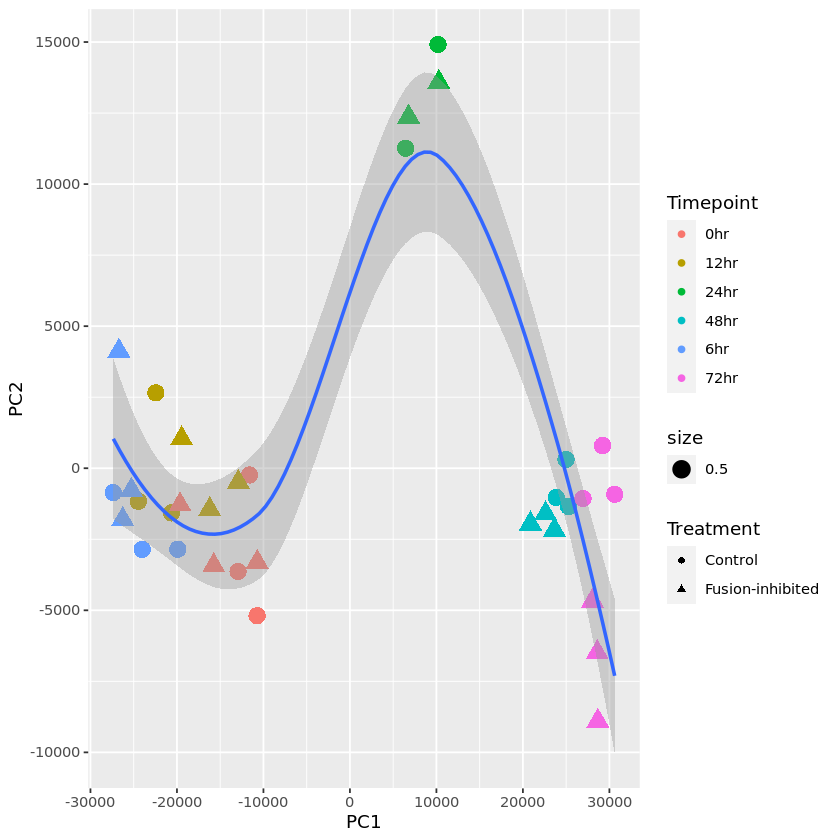

In [6]:
# Grab pca output, stored in "x"
pca_out <- pca$x
head(pca_out) # a matrix with the same number of PCs as samples
pca_out = cbind(pca_out, meta)
ggplot(data = pca_out, mapping = aes(x=PC1, y = PC2))+
  geom_point(mapping = aes(shape = Treatment, color=Timepoint, size = 0.5)) +
  geom_smooth()`

# Differential expression analysis

We can statistically test for differential gene expression. For now, let's look at the results from comparing control Day 0 to control Day 3. Each gene has a logFC or log fold change and Pvalue. 

In [7]:
counts = read.csv("/data/class/cosmos-2022/agarway1/counts_matrix (1).csv")
meta = read.csv("/data/class/cosmos-2022/PUBLIC/voyager/data/c2c12_fusion_metadata.csv",header=T)

# reformat data frame to be a numerical matrix (same as before)
mat = counts[,c(3:ncol(counts))] 
rownames(mat) = counts$Gene_ID

In [8]:
head(counts)
head(mat)

,Gene_ID,Gene_Name,Ctrl_0hr_A,Ctrl_0hr_B,Ctrl_0hr_C,Ctrl_6hr_A,Ctrl_6hr_B,Ctrl_6hr_C,Ctrl_12hr_A,Ctrl_12hr_B,...,FI_12hr_B,FI_12hr_C,FI_24hr_A,FI_24hr_C,FI_48hr_A,FI_48hr_B,FI_48hr_C,FI_72hr_A,FI_72hr_B,FI_72hr_C
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000000001.4,Gnai3,721.0000000,326,637.00000,479.00000,767.00000,409.00000,482.0000,482.000000,...,508.0000000,415.00000,1342.0000,1229.0000,466.0000,230.0000,260.0000000,132.0000,146.00000,206.0000
2,ENSMUSG00000000003.15,Pbsn,0.0000000,0,0.00000,0.00000,0.00000,0.00000,0.0000,0.000000,...,0.0000000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000000,0.0000,0.00000,0.0000
3,ENSMUSG00000000028.15,Cdc45,63.9264600,33,92.75664,60.78799,71.56757,35.55469,118.0000,81.199300,...,72.0000000,89.54172,410.0000,437.2442,151.6271,137.0095,123.2181800,79.0000,84.33859,107.6418
4,ENSMUSG00000000037.16,Scml2,0.9999996,0,2.00000,0.00000,0.00000,1.00000,0.0000,1.000000,...,0.9999996,0.00000,1.0000,1.0000,0.0000,0.0000,0.9999997,1.0000,0.00000,0.0000
5,ENSMUSG00000000049.11,Apoh,2.0000000,1,3.00000,1.00000,1.00000,0.00000,6.0000,5.000001,...,2.0000000,0.00000,0.0000,2.0000,0.0000,1.0000,0.0000000,0.0000,0.00000,0.0000
6,ENSMUSG00000000056.7,Narf,81.0000000,45,87.00002,112.00000,171.00000,86.99997,140.9996,188.000210,...,144.0002200,137.00012,402.0004,379.0002,361.0000,290.9952,233.0002400,222.9999,276.00000,319.0000


,Ctrl_0hr_A,Ctrl_0hr_B,Ctrl_0hr_C,Ctrl_6hr_A,Ctrl_6hr_B,Ctrl_6hr_C,Ctrl_12hr_A,Ctrl_12hr_B,Ctrl_12hr_C,Ctrl_24hr_A,...,FI_12hr_B,FI_12hr_C,FI_24hr_A,FI_24hr_C,FI_48hr_A,FI_48hr_B,FI_48hr_C,FI_72hr_A,FI_72hr_B,FI_72hr_C
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001.4,721.0000000,326,637.00000,479.00000,767.00000,409.00000,482.0000,482.000000,583.000000,483.000000,...,508.0000000,415.00000,1342.0000,1229.0000,466.0000,230.0000,260.0000000,132.0000,146.00000,206.0000
ENSMUSG00000000003.15,0.0000000,0,0.00000,0.00000,0.00000,0.00000,0.0000,0.000000,0.000000,0.000000,...,0.0000000,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000000,0.0000,0.00000,0.0000
ENSMUSG00000000028.15,63.9264600,33,92.75664,60.78799,71.56757,35.55469,118.0000,81.199300,89.993070,190.015624,...,72.0000000,89.54172,410.0000,437.2442,151.6271,137.0095,123.2181800,79.0000,84.33859,107.6418
ENSMUSG00000000037.16,0.9999996,0,2.00000,0.00000,0.00000,1.00000,0.0000,1.000000,0.000000,4.000001,...,0.9999996,0.00000,1.0000,1.0000,0.0000,0.0000,0.9999997,1.0000,0.00000,0.0000
ENSMUSG00000000049.11,2.0000000,1,3.00000,1.00000,1.00000,0.00000,6.0000,5.000001,1.999997,1.000000,...,2.0000000,0.00000,0.0000,2.0000,0.0000,1.0000,0.0000000,0.0000,0.00000,0.0000
ENSMUSG00000000056.7,81.0000000,45,87.00002,112.00000,171.00000,86.99997,140.9996,188.000210,205.999890,319.000410,...,144.0002200,137.00012,402.0004,379.0002,361.0000,290.9952,233.0002400,222.9999,276.00000,319.0000


## EdgeR workflow as a function
This sets up a custom function to compare 2 groups. Nothing will be output when you run this cell. 

In [9]:
# custom function
glm_test = function(mat, meta, comparison){

# Make groups to compare
group <- factor(str_sub(meta$Sample, end=-3)) # trim the rep information (_A)

# read count matrix into DGEList
y=DGEList(counts=mat, group=group)

# Filter lowly expressed genes
keep <- filterByExpr(y)
y <- y[keep, , keep.lib.sizes=FALSE]
y <- calcNormFactors(y)

# indicate reps with design matrix
design = model.matrix(~0+group, data=y$samples)
colnames(design) = levels(y$samples$group)

# fit data to generalized linear model
y=estimateCommonDisp(y)
y=estimateTagwiseDisp(y)
fit = glmQLFit(y, design)

# differential expression test
Contrast <- makeContrasts(contrasts= comparison, levels=design)
qlf <- glmQLFTest(fit, contrast=Contrast)

# Get results
table = qlf$table
table$Gene_ID = rownames(table)
return(table)
}

## This part outputs something
Positive logFC means the gene was expressed higher or "upregulated" in the Day 3 cells compared to Day 0, while negative logFC means the gene was expressed lower or "downregulated" in the Day 3 cells compared to Day 0.

In [10]:
compare = "FI_72hr-Ctrl_72hr" # change this later! e.g. Ctrl_72hr-FI_72hr
table = glm_test(mat,meta,compare)
head(table)

,logFC,logCPM,F,PValue,Gene_ID
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSMUSG00000000001.4,-0.94960407,5.580403,29.23231072,6.282493e-06,ENSMUSG00000000001.4
ENSMUSG00000000028.15,0.19698450,3.431461,1.19762475,2.820539e-01,ENSMUSG00000000028.15
ENSMUSG00000000056.7,-0.77564894,4.424572,42.91615923,2.339802e-07,ENSMUSG00000000056.7
ENSMUSG00000000058.6,-1.11658097,2.771882,10.00508497,3.434475e-03,ENSMUSG00000000058.6
ENSMUSG00000000078.7,-0.59983598,5.736868,24.74439516,2.196969e-05,ENSMUSG00000000078.7
ENSMUSG00000000085.16,-0.02222825,3.759540,0.01932841,8.903098e-01,ENSMUSG00000000085.16


## Format results

Why did we use gene IDs rather than gene names to make our matrix? Unfortunately, there are some duplicate gene names but not gene IDs. We can get the gene names back by merging the differential expression results table with the original counts matrix. See [this page](https://dplyr.tidyverse.org/reference/mutate-joins.html) for more infomation on joining logic in dplyr.

In [11]:
plot_table = left_join(table, counts, by = "Gene_ID")
plot_table$Comparison = compare

table(duplicated(plot_table$Gene_Name)) 
table(duplicated(plot_table$Gene_ID))


FALSE  TRUE 
12760    11 


FALSE 
12771 

## Sort table by log fold change to check top up- and down-regulated genes

In [12]:
head(arrange(plot_table,logFC))
head(arrange(plot_table,-logFC))


,logFC,logCPM,F,PValue,Gene_ID,Gene_Name,Ctrl_0hr_A,Ctrl_0hr_B,Ctrl_0hr_C,Ctrl_6hr_A,...,FI_12hr_C,FI_24hr_A,FI_24hr_C,FI_48hr_A,FI_48hr_B,FI_48hr_C,FI_72hr_A,FI_72hr_B,FI_72hr_C,Comparison
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,-6.539526,3.5212663,11.968933,1.660707e-03,ENSMUSG00000071516.2,Hist1h2ai,317.93500,150.02000,170.26900,96.2969,...,287.05200,2.652660e+01,20.38570,8.91079,0,9.23651,0.00e+00,0,0,FI_72hr-Ctrl_72hr
2,-6.368002,-0.7245475,4.064345,5.529061e-02,ENSMUSG00000116358.1,Gm49450,0.00000,0.00000,0.00000,0.0000,...,0.00000,8.740000e-08,32.84180,37.71650,0,37.16470,4.22e-07,0,0,FI_72hr-Ctrl_72hr
3,-5.979557,0.6782297,22.738610,4.591120e-05,ENSMUSG00000045573.9,Penk,16.00000,9.00000,22.99998,9.0000,...,19.99995,3.300005e+01,26.00000,4.00000,6,4.00000,0.00e+00,0,0,FI_72hr-Ctrl_72hr
4,-5.873698,-0.4207639,3.673861,6.647367e-02,ENSMUSG00000090145.7,Ugt1a6b,5.88026,7.07425,4.57537,34.9177,...,0.43816,0.000000e+00,12.81550,2.96315,0,7.35124,0.00e+00,0,0,FI_72hr-Ctrl_72hr
5,-5.531953,2.6137767,83.487855,2.172992e-10,ENSMUSG00000044041.4,Krt13,84.00000,48.99997,114.00000,98.0000,...,81.00002,6.700000e+01,36.00002,1.00000,1,1.00000,0.00e+00,0,1,FI_72hr-Ctrl_72hr
6,-5.495192,1.2542502,377.397363,7.796719e-14,ENSMUSG00000069873.4,4930438A08Rik,0.00000,0.00000,0.00000,0.0000,...,0.00000,1.000000e+00,0.00000,4.00000,6,6.00000,8.00e+00,3,9,FI_72hr-Ctrl_72hr


,logFC,logCPM,F,PValue,Gene_ID,Gene_Name,Ctrl_0hr_A,Ctrl_0hr_B,Ctrl_0hr_C,Ctrl_6hr_A,...,FI_12hr_C,FI_24hr_A,FI_24hr_C,FI_48hr_A,FI_48hr_B,FI_48hr_C,FI_72hr_A,FI_72hr_B,FI_72hr_C,Comparison
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,5.752468,-0.9435454,11.925203,0.001800253,ENSMUSG00000074269.10,Rec114,10.71666,2.00000,6.87569,7.70453000,...,0.00000,0.0000,2.00000e+00,4.00000,2.00000,0.796184,4.000005,3.83347,10.98029,FI_72hr-Ctrl_72hr
2,5.706678,-0.1328905,7.107441,0.012302595,ENSMUSG00000072676.12,Tmem254a,3.62219,0.00000,9.42360,0.00000000,...,7.14516,25.4912,1.10342e+01,26.16350,22.66682,17.898480,0.000000,2.85758,15.49047,FI_72hr-Ctrl_72hr
3,5.370932,-0.5841236,2.111890,0.158281259,ENSMUSG00000106715.3,Tmem265,14.88580,5.99889,0.00000,21.87640000,...,0.00000,0.0000,0.00000e+00,6.02923,0.00000,6.539370,10.929400,3.02362,0.19845,FI_72hr-Ctrl_72hr
4,5.143954,-1.0739775,3.053823,0.091643580,ENSMUSG00000078495.10,Zfp984,3.17173,3.51739,0.00000,0.00000129,...,0.00000,0.0000,4.86218e-04,6.37680,0.00000,0.000000,4.159670,4.48663,3.49485,FI_72hr-Ctrl_72hr
5,5.141299,-0.8398866,7.202147,0.011792511,ENSMUSG00000092116.1,Gm10320,4.21123,2.45031,7.41092,4.88515000,...,2.08725,6.3465,2.01251e+00,2.50267,1.24987,0.000000,3.660040,0.00000,8.52861,FI_72hr-Ctrl_72hr
6,4.726312,-0.1344837,10.448736,0.003003578,ENSMUSG00000041046.7,Ramp3,13.99996,4.00000,12.00000,7.00000000,...,4.00000,12.0000,1.20000e+01,7.00000,11.00000,8.000000,3.000000,4.00000,2.00000,FI_72hr-Ctrl_72hr


## [Data transformation](https://r4ds.had.co.nz/transform.html#transform)
Categorize each gene as upregulated, downregulated, or no change based on chosen cutoffs |logFC|> 1, Pvalue < 0.01 using [mutate](https://r4ds.had.co.nz/transform.html#add-new-variables-with-mutate) and [logical operators](https://r4ds.had.co.nz/transform.html#logical-operators). `ifelse()` is a base R function. If the gene's logFC >= 2.0 & PValue <  0.01 then it is assigned to be Upregulated category. If not, it is compared to logFC<= -2.0 & PValue <  0.01 and either assigned to Downregulated if these conditions are true, or else No Change.

In [13]:
plot_table <- mutate(plot_table, 
                     Categories = ifelse(logFC >= 0.5 & PValue <  0.01,"Upregulated on Fusion Inhibited day 3", 
                                         ifelse(logFC<= -0.5 & PValue <  0.01 , "Downregulated on Fusion Inhibited day 3", "No Change")))

head(plot_table)

,logFC,logCPM,F,PValue,Gene_ID,Gene_Name,Ctrl_0hr_A,Ctrl_0hr_B,Ctrl_0hr_C,Ctrl_6hr_A,...,FI_24hr_A,FI_24hr_C,FI_48hr_A,FI_48hr_B,FI_48hr_C,FI_72hr_A,FI_72hr_B,FI_72hr_C,Comparison,Categories
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,-0.94960407,5.580403,29.23231072,6.282493e-06,ENSMUSG00000000001.4,Gnai3,721.00000,326.0000,637.00000,479.00000,...,1342.0000,1229.0000,466.00000,230.0000,260.00000,132.00000,146.00000,206.0000,FI_72hr-Ctrl_72hr,Downregulated on Fusion Inhibited day 3
2,0.19698450,3.431461,1.19762475,2.820539e-01,ENSMUSG00000000028.15,Cdc45,63.92646,33.0000,92.75664,60.78799,...,410.0000,437.2442,151.62714,137.0095,123.21818,79.00000,84.33859,107.6418,FI_72hr-Ctrl_72hr,No Change
3,-0.77564894,4.424572,42.91615923,2.339802e-07,ENSMUSG00000000056.7,Narf,81.00000,45.0000,87.00002,112.00000,...,402.0004,379.0002,361.00000,290.9952,233.00024,222.99990,276.00000,319.0000,FI_72hr-Ctrl_72hr,Downregulated on Fusion Inhibited day 3
4,-1.11658097,2.771882,10.00508497,3.434475e-03,ENSMUSG00000000058.6,Cav2,55.00001,34.0000,46.00005,40.99997,...,262.0001,287.0000,53.99999,23.0000,23.00003,12.00000,10.00000,34.0000,FI_72hr-Ctrl_72hr,Downregulated on Fusion Inhibited day 3
5,-0.59983598,5.736868,24.74439516,2.196969e-05,ENSMUSG00000000078.7,Klf6,446.99960,262.9996,569.00000,374.00000,...,945.0000,826.9995,614.00000,559.0000,406.00000,459.00050,561.00000,792.0000,FI_72hr-Ctrl_72hr,Downregulated on Fusion Inhibited day 3
6,-0.02222825,3.759540,0.01932841,8.903098e-01,ENSMUSG00000000085.16,Scmh1,112.99995,49.0000,130.00007,118.99994,...,262.0042,230.0000,170.00005,137.9998,121.00003,91.99989,78.00004,136.0000,FI_72hr-Ctrl_72hr,No Change


In [14]:
table(plot_table$Categories) # how many DE genes?


Downregulated on Fusion Inhibited day 3                               No Change 
                                   1450                                   10136 
  Upregulated on Fusion Inhibited day 3 
                                   1185 

## Volcano Plot: Plot differential expression results
[Filter](https://r4ds.had.co.nz/transform.html#filter-rows-with-filter) the results within `geom_label_repel()` to label the most significant differentially expressed genes .

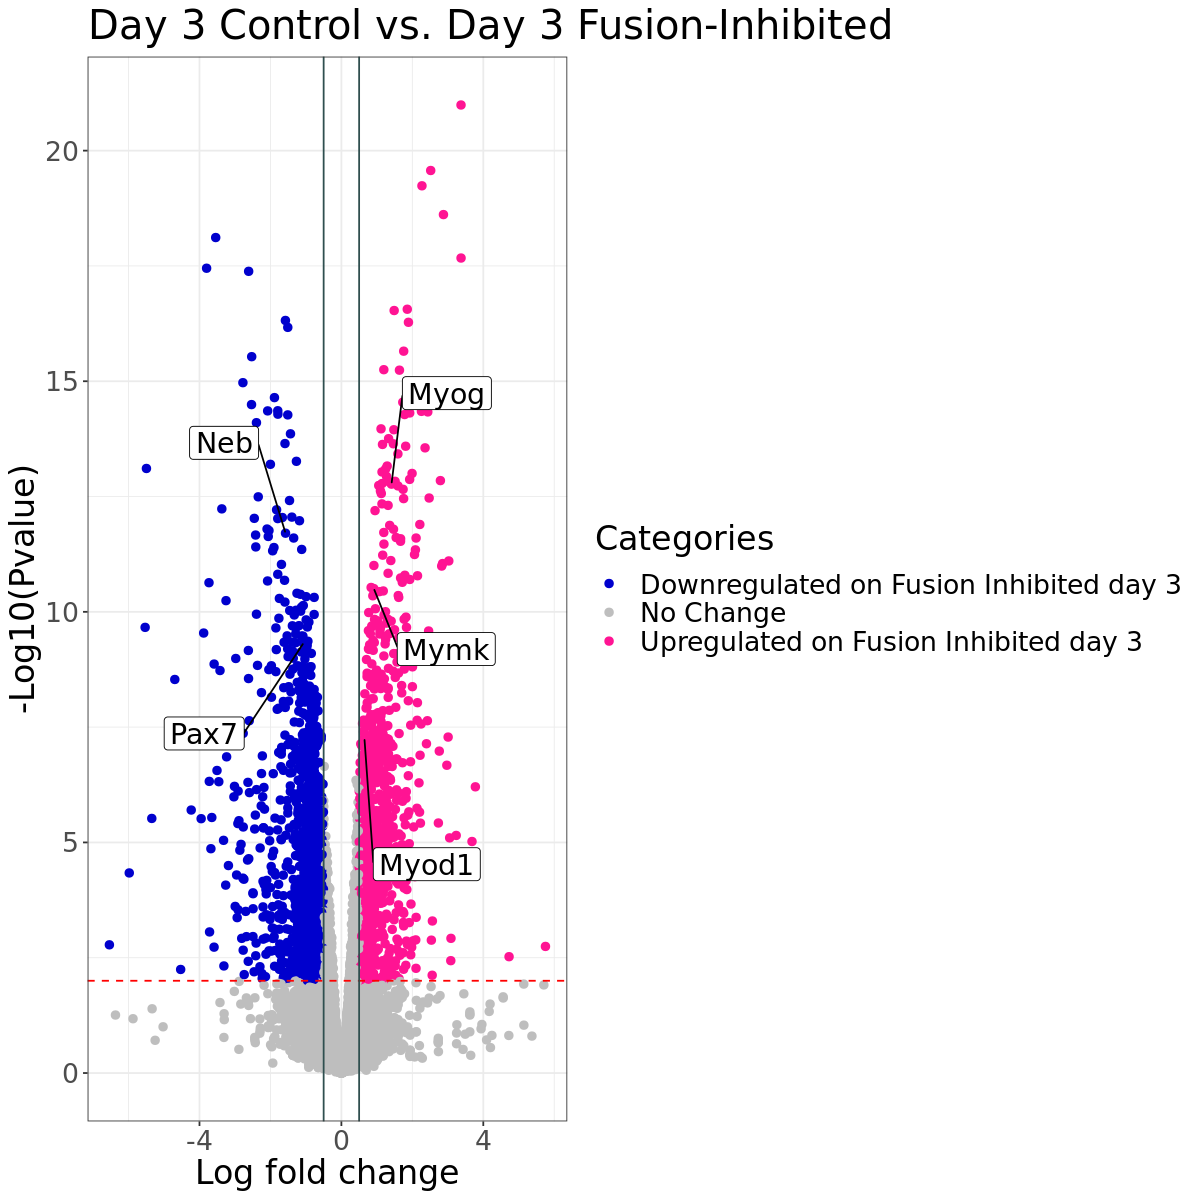

In [15]:
library(ggrepel)

options(repr.plot.width=10, repr.plot.height=10) 
#...."



#...
ggplot(plot_table)+
    geom_point(aes(x=logFC, y=-log10(PValue), color=Categories), 
               size=2) + 
    xlab("Log fold change") + ylab("-Log10(Pvalue)") + 
    geom_label_repel(data = plot_table[plot_table$Gene_Name %in% c("Myod1", "Mymk", "Myog", "Pax7", "Neb"),], # plot top DE genes
                     aes(x=logFC,y=-log10(PValue),label = Gene_Name), size = 6, box.padding = 3, max.overlaps = 150) +
    theme_bw() +
    scale_color_manual(values=c("blue3", "grey", "deeppink1")) +
    theme(text = element_text(size=20)) +
    geom_hline(yintercept=2, linetype="dashed", # add vertical and horizontal lines to indicate significance cutoffs
             color = "red", size=0.5) +
    geom_vline(xintercept=0.5, color = "darkslategrey", size=0.5) +
    geom_vline(xintercept=-0.5, color = "darkslategrey", size=0.5) +
    ggtitle("Day 3 Control vs. Day 3 Fusion-Inhibited")


## Heatmap: Plot differential expression results


In [16]:
library(ComplexHeatmap)

Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




In [17]:
# Input to ComplexHeatmap must be a matrix
plot_table_up = plot_table[plot_table$Gene_Name %in% c("Myod1", "Mymk", "Myog", "Pax7", "Neb"), ]
rownames(plot_table_up) = plot_table_up$Gene_Name
plot_table_up = as.matrix(plot_table_up[,colnames(plot_table) %in% meta$Sample])
# Log transform and scale rows between 0 and 1
plot_table_up = apply(log2(plot_table_up+1), MARGIN = 2, FUN = function(X) (X - min(X))/diff(range(X)))
library(circlize)
col_fun = colorRamp2(c(0, 0.5, 1), c("blue3", "white", "deeppink1"))
head(plot_table_up)

circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




,Ctrl_0hr_A,Ctrl_0hr_B,Ctrl_0hr_C,Ctrl_6hr_A,Ctrl_6hr_B,Ctrl_6hr_C,Ctrl_12hr_A,Ctrl_12hr_B,Ctrl_12hr_C,Ctrl_24hr_A,...,FI_12hr_B,FI_12hr_C,FI_24hr_A,FI_24hr_C,FI_48hr_A,FI_48hr_B,FI_48hr_C,FI_72hr_A,FI_72hr_B,FI_72hr_C
Mymk,0.07596470,0.08924468,0.07474493,0.3215832,0.4041975,0.4048006,0.8407436,0.7294204,0.8204081,0.4436304,...,0.7819378,0.7315435,0.5328378,0.4849179,0.6727350,0.6789311,0.6654875,0.6999431,0.7062735,0.7216227
Myod1,1.00000000,1.00000000,1.00000000,1.0000000,1.0000000,1.0000000,0.9734349,1.0000000,0.9970953,0.3833306,...,1.0000000,1.0000000,0.4519285,0.4129882,0.3393177,0.3281153,0.3432233,0.3892775,0.3777055,0.3816500
Myog,0.00000000,0.12317395,0.12972609,0.5586908,0.5702121,0.5362334,1.0000000,0.9148496,0.9860798,1.0000000,...,0.8632420,0.8111006,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000
Neb,0.09626388,0.00000000,0.00000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,...,0.0000000,0.0000000,0.0000000,0.0000000,0.3418726,0.3694423,0.3711602,0.4697140,0.4909823,0.4881434
Pax7,0.84787775,0.78411441,0.82395508,0.8748036,0.8841818,0.9306409,0.9848270,0.9477325,1.0000000,0.3269713,...,0.9498557,0.9068724,0.2929167,0.2806597,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000


Warning message in order(as.numeric(gsub("column", "", colnames(plot_table_up)))):
"NAs introduced by coercion"


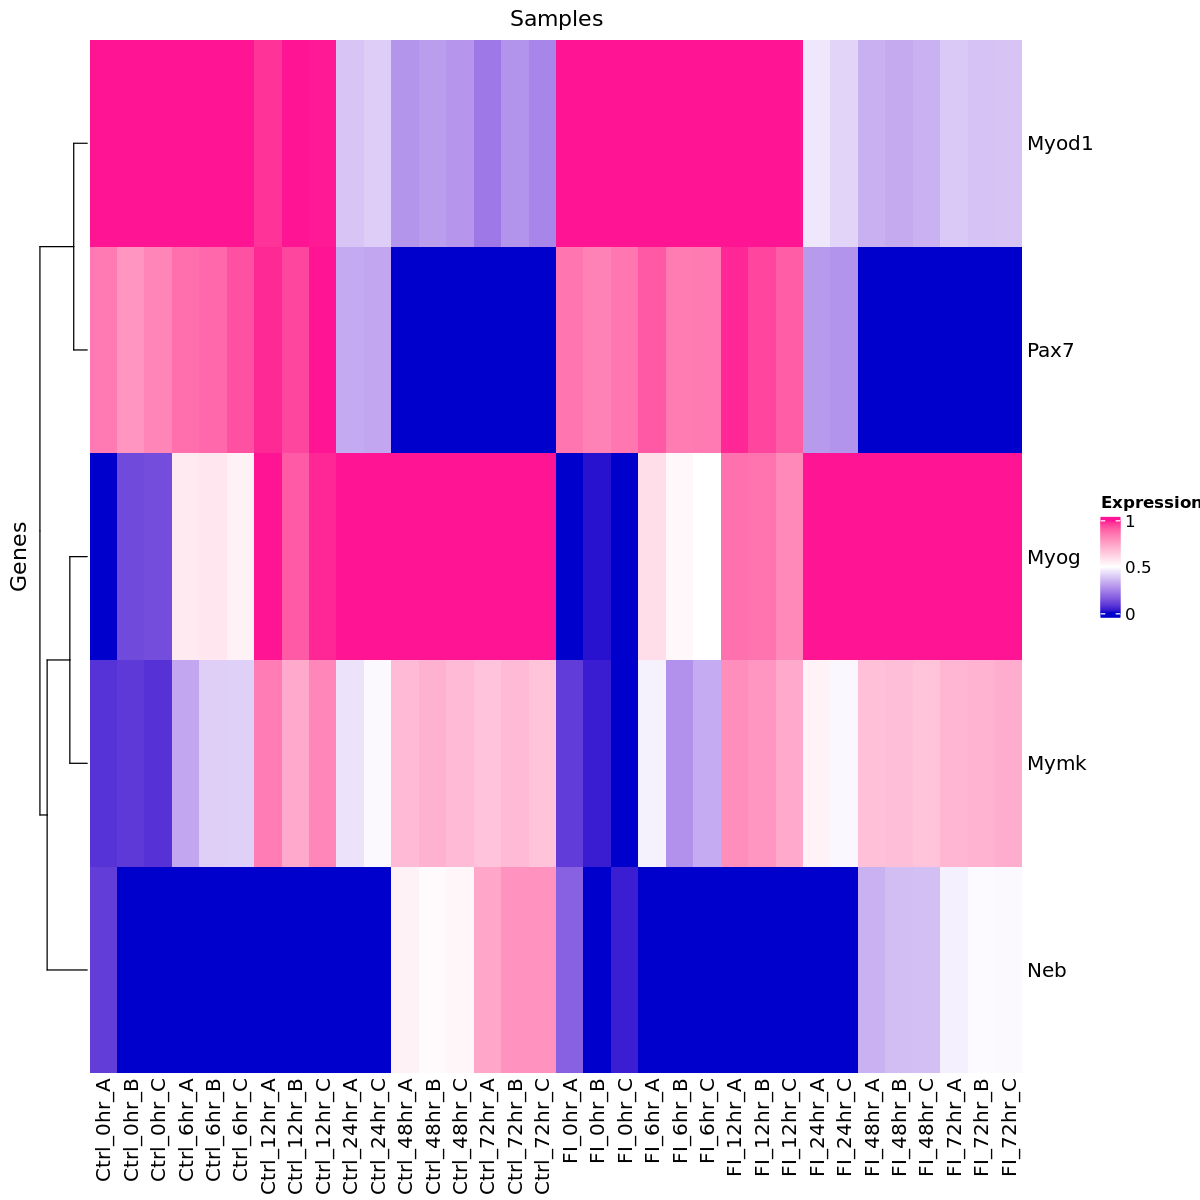

In [18]:
Heatmap(plot_table_up, show_row_names = TRUE, col = col_fun, column_order = order(as.numeric(gsub("column", "", colnames(plot_table_up)))),  name = "Expression", column_title = "Samples",
    row_title = "Genes")